# ST-GCN Dance Pose Generation Pipeline (MiniBatch K-Means Approach)

This notebook implements the second methodological phase: **Mini Batch K-Means Clustering with ST-GCN**.

The pipeline performs the following steps:
1.  **Preprocessing:** Downsample video frames, extract 99-D normalized pose vectors (as per the document's normalization steps).
2.  **Global Model Training & Saving:**
    * Fit and save the **PCA model** (for dimensionality reduction, typically to 32D).
    * Fit and save the **MiniBatch K-Means model** (for keyframe/canonical pose selection).
3.  **ST-GCN Training:** Use the full, normalized 99-D pose sequences to train the ST-GCN Regressor to predict the next 99-D pose vector autoregressively.
4.  **Inference:** Load all saved models/objects and generate continuous future pose sequences.
"""

In [2]:
!pip install opencv-python-headless mediapipe scikit-learn torch tqdm matplotlib pyvista
!apt-get install -y xvfb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 8.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
import argparse
import json
import math
import glob
import random
import pickle # Used for saving/loading sklearn models (PCA, KMeans)
from pathlib import Path
from collections import deque
from datetime import datetime

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ML libs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import pyvista as pv


In [19]:
# MediaPipe
try:
    import mediapipe as mp
    mp_pose = mp.solutions.pose
    # POSE_DETECTOR initialization block
    POSE_DETECTOR = mp_pose.Pose(static_image_mode=False,
                                 model_complexity=1,
                                 enable_segmentation=False,
                                 min_detection_confidence=0.5,
                                 min_tracking_confidence=0.5)
except Exception as e:
    mp = None
    POSE_DETECTOR = None
    print("MediaPipe not fully initialized.")

# Start the virtual framebuffer for PyVista 3D rendering (Colab requirement)
pv.start_xvfb()

# ---------------------------
# Configuration (Refined to ensure all necessary files are saved)
# ---------------------------
CFG = {
    # File Paths (Adjust these paths to your Google Drive structure)
    "drive_videos_dir": "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos",
    "output_dir": "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN",

    # Preprocessing/Feature Extraction Config
    "proc_fps": 4,              # Frame rate for processing
    "sample_videos": 10,        # Limit to 15 videos for demonstration/speed
    "random_seed": 42,

    # PCA/Clustering Config (for canonical pose space creation)
    "use_pca": True,
    "pca_dims": 32,
    "n_keyframes": 25,          # 25 K-Means clusters

    # ST-GCN Training/Model Config
    "seq_len": 32,              # ST-GCN input length (T)
    "pred_horizon": 1,          # Predict next frame (t+1)
    "batch_size": 8,
    "epochs": 10,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model_path": "stgcn_regressor.pth", # ST-GCN weights file
    "pca_model_path": "pca_transformer.pkl", # PCA transformer file
    "kmeans_model_path": "kmeans_clusters.pkl", # K-Means cluster model
}

# Set seeds
random.seed(CFG["random_seed"]); np.random.seed(CFG["random_seed"]); torch.manual_seed(CFG["random_seed"])


In [6]:
# ---------------------------
# Pose Extraction & Normalization Utilities
# ---------------------------

def sample_frames_from_video(video_path, sample_fps):
    """Generator to sample frames from a video at a specified FPS."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open {video_path}")
        return
    video_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    step = max(1, int(round(video_fps / sample_fps)))
    idx = 0
    with tqdm(total=total, desc=f"Sampling {os.path.basename(video_path)}") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if idx % step == 0:
                # Returns 3D BGR frame
                yield idx, idx / video_fps, frame
            idx += 1
            pbar.update(1)
    cap.release()


In [30]:
def extract_pose_landmarks(image_bgr):
    """Extracts 33 3D landmarks from a BGR image using MediaPipe."""
    if POSE_DETECTOR is None:
        raise RuntimeError("MediaPipe not available.")
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = POSE_DETECTOR.process(img_rgb)
    if not results.pose_landmarks:
        return None
    # Extract x, y, z coordinates
    landmarks = [[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
    return np.array(landmarks, dtype=np.float32)  # (33, 3)

def normalize_landmarks(landmarks):
    """
    Normalizes 33x3 landmarks based on torso length and hip midpoint.
    Output is a flattened 99-D vector.
    """
    if landmarks is None:
        return None

    # P_i: landmarks[:, :2] uses 2D coordinates (x, y) for normalization,
    # then applies the scale/translation to 3D landmarks.

    # 1. Translation Normalization (Hip Mid-point)
    # P23 (left hip), P24 (right hip)
    left_hip, right_hip = landmarks[23, :], landmarks[24, :]
    # Calculate P_hip = (P23 + P24) / 2
    hip_mid = (left_hip + right_hip) / 2.0

    # P_i' = P_i - P_hip (subtract hip mid-point from every joint coordinate)
    centered = landmarks - hip_mid

    # 2. Scale Normalization (Torso Length)
    # P11 (left shoulder), P12 (right shoulder)
    left_shoulder, right_shoulder = landmarks[11, :], landmarks[12, :]
    # Calculate P_shoulder = (P11 + P12) / 2
    shoulder_mid = (left_shoulder + right_shoulder) / 2.0

    # L_torso = ||P_shoulder - P_hip||_2
    torso_vec = shoulder_mid - hip_mid
    torso_len = np.linalg.norm(torso_vec)

    if torso_len < 1e-6: torso_len = 1.0 # Avoid division by zero

    # P_i'' = P_i' / L_torso (scaling all centered coordinates)
    # Flatten to 99 dimensions (33 joints * 3 coords)
    normalized = (centered / torso_len).flatten()
    return normalized # (99,)

# ---------------------------
# NEW UTILITY FUNCTION GOES HERE
# ---------------------------
def get_seed_sequence_from_video(video_path, proc_fps, seq_len):
    """
    Processes a single video, extracts normalized pose vectors, and returns
    the first 'seq_len' frames to use as the prediction seed.
    """
    frames_vecs = []
    video_name = os.path.basename(video_path)
    print(f"\n--- Processing selected video: {video_name} ---")

    # Use the same sampling and normalization logic as training
    for f_idx, ts, frame in sample_frames_from_video(video_path, proc_fps):
        lm = extract_pose_landmarks(frame)
        if lm is None: continue
        frames_vecs.append(normalize_landmarks(lm))

    if len(frames_vecs) < seq_len:
        raise ValueError(
            f"Video '{video_name}' has only {len(frames_vecs)} usable frames, "
            f"but requires a minimum sequence length of {seq_len} for the seed."
        )

    # Return the first T frames as the seed sequence
    seed_sequence = np.stack(frames_vecs[:seq_len], axis=0)
    print(f"Successfully extracted {len(frames_vecs)} frames. Using first {seq_len} frames as seed.")
    return seed_sequence

In [8]:
# ---------------------------
# Keyframe/Canonical Pose Logic
# ---------------------------

def find_canonical_keyframes(X_reduced, X_full, pca_model, kmeans_model):
    """
    Identifies the canonical keyframe (the pose closest to each cluster centroid)
    and returns the 99-D vectors of those poses.

    Note: This function is for visualization/analysis, not ST-GCN training data creation.
    """
    if X_reduced.shape[0] == 0:
        return []

    # If PCA was used, ensure X_reduced is used for clustering/distance calculation
    if pca_model:
        X_to_cluster = X_reduced
    else:
        X_to_cluster = X_full

    n_clusters = kmeans_model.n_clusters
    labels = kmeans_model.predict(X_to_cluster)

    keyframe_vectors = []

    for cid in range(n_clusters):
        members_idx = np.where(labels == cid)[0]
        if len(members_idx) == 0: continue

        center = kmeans_model.cluster_centers_[cid]

        # Calculate distances from all members of the cluster to the centroid
        dists = np.linalg.norm(X_to_cluster[members_idx] - center, axis=1)

        # Find the index in the original X_full array corresponding to the closest pose
        closest_relative_idx = np.argmin(dists)
        closest_original_idx = members_idx[closest_relative_idx]

        keyframe_vectors.append(X_full[closest_original_idx])

    return keyframe_vectors

In [9]:
# ---------------------------
# ST-GCN simplified model for regression (PyTorch)
# ---------------------------
# The model definition must be saved in the notebook/file for loading to work.

class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size,1),
                              padding=(padding,0), stride=(stride,1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        # x: (B, C, T, V)
        return self.act(self.bn(self.conv(x)))

In [10]:
class STBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.tconv = TemporalConv(in_channels, out_channels, kernel_size=kernel_size)
        # Spatial mixing is implicitly done here by a 1x1 convolution
        self.sconv = nn.Conv2d(out_channels, out_channels, kernel_size=(1,1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        # x shape: (B, C, T, V)
        x = self.tconv(x)    # temporal conv
        x = self.sconv(x)    # spatial mixing across joints (via 1x1 conv)
        x = self.bn(x)
        return self.act(x)

In [11]:
class STGCNRegressor(nn.Module):
    def __init__(self, in_channels=3, num_joints=33, seq_len=32, hidden_channels=[64,128,256]):
        super().__init__()
        # Input: (B, C=3, T, V=33)
        self.input_proj = nn.Conv2d(in_channels, hidden_channels[0], kernel_size=(1,1))
        self.blocks = nn.ModuleList()
        ch_in = hidden_channels[0]
        for h in hidden_channels:
            self.blocks.append(STBlock(ch_in, h))
            ch_in = h

        # Global pooling & final regressor to 3*num_joints (single-frame prediction)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(hidden_channels[-1], num_joints * 3)  # predict flattened 99 vector

    def forward(self, x):
        # x: (B, C=3, T, V=33)
        x = self.input_proj(x)  # (B, H0, T, V)
        for b in self.blocks:
            x = b(x)
        x = self.pool(x)  # (B, H, 1, 1)
        x = x.view(x.size(0), -1)  # (B, H)
        out = self.fc(x)  # (B, 99)
        return out


In [23]:
# ---------------------------
# Dataset
# ---------------------------
class PoseSequenceDataset(Dataset):
    def __init__(self, sequences, seq_len=32, pred_horizon=1):
        # sequences: list of arrays shape (T, D) where D=99
        self.inputs = []
        self.targets = []
        for seq in sequences:
            T = seq.shape[0]
            # Slide window by 1 (stride of 1 is implicit)
            for i in range(0, T - seq_len - pred_horizon + 1, 1):
                inp = seq[i: i + seq_len]  # (seq_len, 99)
                tgt = seq[i + seq_len + pred_horizon - 1]  # single target frame
                self.inputs.append(inp)
                self.targets.append(tgt)

        if len(self.inputs)==0:
            print(f"Warning: No training samples generated. Total sequences length: {sum(s.shape[0] for s in sequences)}")
            self.inputs = np.zeros((0, seq_len, 99), dtype=np.float32)
            self.targets = np.zeros((0, 99), dtype=np.float32)
        else:
            self.inputs = np.stack(self.inputs, axis=0).astype(np.float32)  # (N, seq_len, 99)
            self.targets = np.stack(self.targets, axis=0).astype(np.float32)  # (N, 99)
        self.seq_len = seq_len

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        inp = self.inputs[idx]  # (seq_len, 99)
        tgt = self.targets[idx]

        # FIX: Ensure correct (C, T, V) shape for ST-GCN input: (3, seq_len, 33)
        # inp: (seq_len, 99) -> reshape (T, V, C) -> permute/transpose to (C, T, V)
        inp_reshaped = inp.reshape(self.seq_len, 33, 3) # (T, V, C)

        # Convert to tensor and permute C to the front: (T, V, C) -> (C, T, V)
        # This is the standard (Channels, Time, Vertices) input format.
        inp_tensor = torch.from_numpy(inp_reshaped).permute(2, 0, 1) # (3, T, 33)

        return inp_tensor, torch.from_numpy(tgt)

-------------------------------------------------
# **Model Training**
-------------------------------------------------

In [13]:
# ---------------------------
# Training / evaluation helpers (No change, as they were mostly correct)
# ---------------------------
def euclidean_distance(a, b):
    # a,b are (N,99). Convert to (N, 33, 3) for joint distance.
    a = a.reshape(a.shape[0], 33, 3)
    b = b.reshape(b.shape[0], 33, 3)
    d = np.linalg.norm(a - b, axis=2)  # (N,33) per-joint distance
    return d.mean(axis=1)  # per-sample mean joint distance

def cosine_sim(a, b):
    # compute per-sample cosine between flattened vectors
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-8)
    return (a_norm * b_norm).sum(axis=1) # per-sample cosine similarity

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cpu', model_save_path=None):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float('inf')

    for ep in range(epochs):
        model.train()
        running = 0.0
        count = 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {ep+1} Training"):
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            count += xb.size(0)
        train_loss = running / max(1, count)

        val_loss = 0.0
        vcount = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {ep+1} Validation"):
                xb = xb.to(device); yb = yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                vcount += xb.size(0)
        val_loss = val_loss / max(1, vcount) if vcount>0 else 0.0

        history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
        print(f"Epoch {ep+1}/{epochs}  Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss and model_save_path:
            best_val_loss = val_loss
            torch.save({"model_state": model.state_dict(), "cfg": CFG}, str(model_save_path))
            print(f"  ✅ Saved best model to: {model_save_path} (Loss: {best_val_loss:.6f})")

    return model, history


-------------------------------------------------
# **Evaluate Model**
-------------------------------------------------

In [14]:
def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    preds = []; gts = []
    with torch.no_grad():
        for xb, yb in tqdm(data_loader, desc="Evaluating"):
            xb = xb.to(device)
            out = model(xb).cpu().numpy()  # (B,99)
            preds.append(out); gts.append(yb.numpy())
    if len(preds)==0:
        return {"mse":0.0,"mean_euc":0.0,"mean_cos":0.0}, np.zeros((0,99)), np.zeros((0,99))
    preds = np.vstack(preds); gts = np.vstack(gts)
    mse = ((preds - gts) ** 2).mean()
    euc = euclidean_distance(preds, gts).mean()
    # Cosine similarity uses 1 for perfect match, so we take 1 - mean(cos) as error
    cos = cosine_sim(preds, gts).mean()
    return {"mse": float(mse), "mean_euc": float(euc), "mean_cos": float(cos)}, preds, gts


-------------------------------------------------
# **Ploting Visuals**
-------------------------------------------------

In [15]:
# ---------------------------
# Visualization Utilities
# ---------------------------

# MediaPipe Pose connections
MP_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8), # Head/Face
    (9,10),(11,12),(11,13),(13,15),(12,14),(14,16), # Arms
    (23,24),(11,23),(12,24),(23,25),(24,26),(25,27),(26,28) # Torso/Legs/Hips
]

def plot_stickman(ax, vec99, title="Pose"):
    """Plots a 99-D normalized pose vector as a 2D stick figure."""
    arr = vec99.reshape(33,3)
    xs = arr[:,0]; ys = -arr[:,1] # Invert y for standard plot orientation

    # Calculate plot limits based on normalized coords
    x_min, x_max = xs.min() - 0.1, xs.max() + 0.1
    y_min, y_max = ys.min() - 0.1, ys.max() + 0.1

    ax.scatter(xs, ys, s=10)
    for a,b in MP_CONNECTIONS:
        if a < 33 and b < 33:
            ax.plot([xs[a], xs[b]], [ys[a], ys[b]], 'k-', linewidth=2, marker='o', markersize=3)

    ax.set_title(title);
    ax.set_xlim(x_min, x_max);
    ax.set_ylim(y_min, y_max);
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')


In [16]:
def plot_3d_mannequin(vec99, filename="pose_3d.png"):
    """Renders a 33-keypoint pose vector as a 3D mannequin using PyVista."""
    landmarks = vec99.reshape(33, 3).copy()
    landmarks[:, 1] = -landmarks[:, 1] # Invert Y-axis for upright stance

    p = pv.Plotter(off_screen=True, window_size=[800, 800])
    p.set_background("white")

    for a, b in MP_CONNECTIONS:
        if a < 33 and b < 33:
            point_a = landmarks[a]
            point_b = landmarks[b]
            line = pv.Line(point_a, point_b)
            tube = line.tube(radius=0.025)
            p.add_mesh(tube, color="#E0AC69", smooth_shading=True)

    for point in landmarks:
        sphere = pv.Sphere(radius=0.035, center=point)
        p.add_mesh(sphere, color="#FF5555", smooth_shading=True)

    p.view_xy()
    p.camera.zoom(1.2)
    p.show(screenshot=filename)
    p.close()
    print(f"Saved 3D visualization to {filename}")

-------------------------------------------------
# **Global Preprocessing, Training & Saving**
-------------------------------------------------

In [17]:
# ---------------------------
# Global Preprocessing, Training & Saving
# ---------------------------

def global_preprocess_and_save_pipeline(vpaths, out_dir, CFG):
    """
    Step 1 & 2: Extracts all 99-D normalized pose vectors,
    fits and saves PCA and MiniBatch K-Means models.
    Returns the list of sequences for ST-GCN training.
    """
    all_normalized_vecs = []
    video_sequences = []

    print("\n--- 1. Extracting ALL Normalized Pose Vectors ---")
    for vp in vpaths:
        frames_vecs = []
        for f_idx, ts, frame in sample_frames_from_video(vp, CFG["proc_fps"]):
            lm = extract_pose_landmarks(frame)
            if lm is None: continue
            vec99 = normalize_landmarks(lm)
            frames_vecs.append(vec99)
            all_normalized_vecs.append(vec99)

        if len(frames_vecs) >= CFG["seq_len"] + CFG["pred_horizon"]:
            seq_arr = np.stack(frames_vecs, axis=0)
            video_sequences.append(seq_arr)
        else:
            print(f"Skipping {vp}: not enough pose frames ({len(frames_vecs)}) for sequence length {CFG['seq_len']}")

    X_all = np.stack(all_normalized_vecs, axis=0)
    print(f"Total poses extracted for fitting: {X_all.shape[0]}")

    if X_all.shape[0] == 0:
        print("FATAL: No pose data extracted. Cannot proceed.")
        return [], None, None

    # --- 2. Train and Save PCA ---
    pca_model = None
    X_reduced = X_all
    pca_save_path = out_dir / CFG["pca_model_path"]

    if CFG["use_pca"]:
        n_comp = min(CFG["pca_dims"], X_all.shape[1], X_all.shape[0])
        pca_model = PCA(n_components=n_comp, random_state=CFG["random_seed"])
        X_reduced = pca_model.fit_transform(X_all)
        print(f"PCA fitted. Reduced {X_all.shape[1]}D to {X_reduced.shape[1]}D.")

        with open(pca_save_path, 'wb') as f:
            pickle.dump(pca_model, f)
        print(f"✅ PCA model saved to: {pca_save_path}")

    # --- 3. Train and Save MiniBatch K-Means ---
    kmeans_model = None
    kmeans_save_path = out_dir / CFG["kmeans_model_path"]

    n_clusters = min(CFG["n_keyframes"], X_reduced.shape[0])
    kmeans_model = MiniBatchKMeans(n_clusters=n_clusters,
                                   random_state=CFG["random_seed"],
                                   batch_size=256, n_init='auto',
                                   verbose=False)
    kmeans_model.fit(X_reduced)
    print(f"MiniBatch K-Means fitted with K={n_clusters}.")

    with open(kmeans_save_path, 'wb') as f:
        pickle.dump(kmeans_model, f)
    print(f"✅ K-Means model saved to: {kmeans_save_path}")

    # --- 4. Keyframe Analysis (For representation/visualization only) ---
    # Example: Find and print the first 5 canonical poses
    keyframe_vecs = find_canonical_keyframes(X_reduced, X_all, pca_model, kmeans_model)
    print(f"Identified {len(keyframe_vecs)} canonical keyframes.")

    return video_sequences, pca_model, kmeans_model

-------------------------------------------------
# **Main File**
-------------------------------------------------

In [18]:
def main(args):
    # --- Setup ---
    out_dir = Path(args.output_dir or CFG["output_dir"]); out_dir.mkdir(parents=True, exist_ok=True)
    drive_dir = Path(args.drive_path or CFG["drive_videos_dir"])
    vpaths = sorted(glob.glob(str(drive_dir / "*.*")))
    vpaths = [p for p in vpaths if p.lower().endswith(('.mp4','.mov','.avi','.mkv','.webm'))]
    vpaths = vpaths[: args.n_videos or CFG["sample_videos"]]
    print(f"Found {len(vpaths)} eligible videos. Processing {len(vpaths)} videos...")

    # --- Step A: Global Preprocessing (PCA/K-Means) & Data Collection ---
    sequences, pca_model, kmeans_model = global_preprocess_and_save_pipeline(vpaths, out_dir, CFG)

    if not sequences:
        print("No sequences available for training.")
        return

    # --- Step B: Prepare ST-GCN Training Data ---
    random.shuffle(sequences)
    n_train = int(0.8 * len(sequences))
    train_seqs = sequences[:n_train]; val_seqs = sequences[n_train:]

    train_ds = PoseSequenceDataset(train_seqs, seq_len=CFG["seq_len"], pred_horizon=CFG["pred_horizon"])
    val_ds = PoseSequenceDataset(val_seqs, seq_len=CFG["seq_len"], pred_horizon=CFG["pred_horizon"])

    print(f"\n--- 5. Dataset Prepared ---")
    print(f"Total sequences processed: {len(sequences)}")
    print(f"Train samples: {len(train_ds)}  Val samples: {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False)

    # --- Step C: Build and Train ST-GCN ---
    model = STGCNRegressor(in_channels=3, num_joints=33, seq_len=CFG["seq_len"], hidden_channels=[64,128,256])
    print(f"\n--- 6. Model Built ---")
    print(f"Model built. Parameters: {sum(p.numel() for p in model.parameters()):,}")

    stgcn_save_path = out_dir / CFG["model_path"]
    model, history = train_model(model, train_loader, val_loader,
                                 epochs=args.epochs or CFG["epochs"],
                                 lr=args.lr or CFG["lr"], device=CFG["device"],
                                 model_save_path=stgcn_save_path)

    print(f"\n✅ ST-GCN Model successfully saved (best checkpoint): {stgcn_save_path}")

    # --- Step D: Evaluation and Visualization ---

    # Plot training history (Graph)
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(history["train_loss"], label="Train Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss (MSE)"); ax.legend(); ax.set_title("Training Loss History")
    plt.tight_layout()
    plt.savefig(out_dir / "training_loss.png")
    print("\nSaved training loss plot to", out_dir / "training_loss.png")

    # Final evaluation (using the best saved model state)
    best_model = STGCNRegressor(in_channels=3, num_joints=33, seq_len=CFG["seq_len"], hidden_channels=[64,128,256])
    checkpoint = torch.load(str(stgcn_save_path), map_location=CFG["device"])
    best_model.load_state_dict(checkpoint['model_state'])
    best_model.to(CFG["device"])

    metrics, preds, gts = evaluate_model(best_model, val_loader, device=CFG["device"])
    print("\n--- 7. Final Validation Metrics (Best Model) ---")
    print(json.dumps(metrics, indent=2))

    # Single sample visualization
    if len(val_ds)>0:
        sample_inp, sample_gt = val_ds[0]
        best_model.eval()
        with torch.no_grad():
            inp = sample_inp.unsqueeze(0).to(CFG["device"])
            pred = best_model(inp).cpu().numpy()[0]

        # 2D Stickman Plot
        fig, axes = plt.subplots(1,3, figsize=(12,4))
        input_last_frame = sample_inp.permute(1, 2, 0).numpy()[-1].flatten()
        plot_stickman(axes[0], input_last_frame, title=f"Input Frame (t={CFG['seq_len']})")
        plot_stickman(axes[1], sample_gt.numpy(), title=f"Ground Truth (t+{CFG['pred_horizon']})")
        plot_stickman(axes[2], pred, title=f"Predicted Pose (t+{CFG['pred_horizon']})")
        plt.tight_layout()
        plt.savefig(out_dir / "pred_vs_gt_stickman.png")
        print("Saved predicted vs gt stickman to", out_dir / "pred_vs_gt_stickman.png")

        # 3D Mannequin Plot (requires PyVista setup)
        gt_filename = str(out_dir / "ground_truth_3d.png")
        plot_3d_mannequin(sample_gt.numpy(), filename=gt_filename)
        pred_filename = str(out_dir / "predicted_3d.png")
        plot_3d_mannequin(pred, filename=pred_filename)

-------------------------------------------------
# **Model Loading**
-------------------------------------------------

In [27]:
# ------------------------------------------------------
# INFERENCE: Function to load and generate new poses
# ------------------------------------------------------

def load_pipeline_models(out_dir, minimal_cfg):
    """
    Loads all necessary pre-trained models/transformers for inference.
    It retrieves the full original CFG from the ST-GCN checkpoint file.
    """
    try:
        device = minimal_cfg["device"]

        # 1. Load ST-GCN Regressor Checkpoint to retrieve saved CFG
        stgcn_save_path = out_dir / minimal_cfg["model_path"]
        checkpoint = torch.load(str(stgcn_save_path), map_location=device)
        LOADED_CFG = checkpoint['cfg'] # <--- EXTRACT THE ORIGINAL CFG

        print(f"✅ Retrieved original training configuration (seq_len={LOADED_CFG['seq_len']}, device={LOADED_CFG['device']})")

        # 2. Initialize ST-GCN Model using the LOADED_CFG parameters
        model = STGCNRegressor(
            in_channels=3,
            num_joints=33,
            seq_len=LOADED_CFG["seq_len"],
            hidden_channels=[64,128,256] # Assuming fixed hidden channels
        )
        model.load_state_dict(checkpoint['model_state'])
        model.to(device)
        model.eval()
        print(f"✅ Loaded ST-GCN Regressor from: {stgcn_save_path}")

        # 3. Load PCA Model (requires original model_path entry)
        pca_save_path = out_dir / minimal_cfg["pca_model_path"]
        with open(pca_save_path, 'rb') as f:
            pca_model = pickle.load(f)
        print(f"✅ Loaded PCA model from: {pca_save_path}")

        # 4. Load K-Means Model
        kmeans_save_path = out_dir / minimal_cfg["kmeans_model_path"]
        with open(kmeans_save_path, 'rb') as f:
            kmeans_model = pickle.load(f)
        print(f"✅ Loaded K-Means model from: {kmeans_save_path}")

        # Return the models AND the definitive configuration dictionary
        return model, pca_model, kmeans_model, LOADED_CFG

    except Exception as e:
        print(f"❌ Error loading models. Check path or ensure model definitions are run: {e}")
        return None, None, None, None


def predict_pose_sequence(model, initial_sequence, num_frames_to_generate, device, seq_len):
    """
    Performs autoregressive prediction (sequence generation) using the ST-GCN.

    Args:
        model: Trained STGCNRegressor in eval mode.
        initial_sequence: np.array of shape (T, 99) (the seed sequence).
        num_frames_to_generate: How many future frames to predict.

    Returns:
        np.array of shape (T + num_frames, 99)
    """

    if model is None:
        return np.array([])

    # Initialize the history with the seed sequence
    pose_history = deque(initial_sequence.tolist(), maxlen=seq_len)
    generated_poses = initial_sequence.tolist()

    with torch.no_grad():
        for _ in tqdm(range(num_frames_to_generate), desc="Generating Future Poses"):
            # 1. Prepare input: (T, 99) -> (1, C=3, T, V=33)
            input_array = np.array(list(pose_history), dtype=np.float32) # (seq_len, 99)

            # FIX APPLIED HERE:
            # 1a. Reshape from (T, 99) -> (T, 33, 3)
            input_reshaped = input_array.reshape(seq_len, 33, 3)

            # 1b. Convert to tensor and permute C to the front: (T, V, C) -> (C, T, V)
            input_tensor = torch.from_numpy(input_reshaped).permute(2, 0, 1) # (3, T, 33)

            input_tensor = input_tensor.unsqueeze(0).to(device) # (1, 3, T, 33)

            # 2. Predict next pose: Output is (1, 99)
            pred_pose = model(input_tensor).cpu().numpy()[0] # (99,)

            # 3. Update history (autoregressive loop)
            pose_history.append(pred_pose)
            generated_poses.append(pred_pose)

    return np.array(generated_poses)

-------------------------------------------------
# **Execution Block**
-------------------------------------------------

Starting ST-GCN Dance Pose Prediction Pipeline (Colab Mode)...

Output files will be saved to: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458

Found 10 eligible videos. Processing 10 videos...

--- 1. Extracting ALL Normalized Pose Vectors ---


Sampling Korvai Adavu2.4.mp4: 100%|██████████| 2730/2730 [00:31<00:00, 86.03it/s]


Total poses extracted for fitting: 4019
PCA fitted. Reduced 99D to 32D.
✅ PCA model saved to: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/pca_transformer.pkl
MiniBatch K-Means fitted with K=25.
✅ K-Means model saved to: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/kmeans_clusters.pkl
Identified 25 canonical keyframes.

--- 5. Dataset Prepared ---
Total sequences processed: 10
Train samples: 3089  Val samples: 610

--- 6. Model Built ---
Model built. Parameters: 249,571


Epoch 1 Validation: 100%|██████████| 77/77 [00:00<00:00, 431.83it/s]


Epoch 1/10  Train Loss: 0.175734  Val Loss: 0.128918
  ✅ Saved best model to: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/stgcn_regressor.pth (Loss: 0.128918)


Epoch 2 Validation: 100%|██████████| 77/77 [00:00<00:00, 346.50it/s]


Epoch 2/10  Train Loss: 0.132625  Val Loss: 0.183780


Epoch 3 Validation: 100%|██████████| 77/77 [00:00<00:00, 417.43it/s]


Epoch 3/10  Train Loss: 0.122814  Val Loss: 0.132219


Epoch 4 Validation: 100%|██████████| 77/77 [00:00<00:00, 432.71it/s]


Epoch 4/10  Train Loss: 0.116356  Val Loss: 0.106536
  ✅ Saved best model to: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/stgcn_regressor.pth (Loss: 0.106536)


Epoch 5 Validation: 100%|██████████| 77/77 [00:00<00:00, 427.53it/s]


Epoch 5/10  Train Loss: 0.109571  Val Loss: 0.106694


Epoch 6 Validation: 100%|██████████| 77/77 [00:00<00:00, 367.80it/s]


Epoch 6/10  Train Loss: 0.103057  Val Loss: 0.106711


Epoch 7 Validation: 100%|██████████| 77/77 [00:00<00:00, 432.10it/s]


Epoch 7/10  Train Loss: 0.095585  Val Loss: 0.102356
  ✅ Saved best model to: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/stgcn_regressor.pth (Loss: 0.102356)


Epoch 8 Validation: 100%|██████████| 77/77 [00:00<00:00, 426.97it/s]


Epoch 8/10  Train Loss: 0.093581  Val Loss: 0.110170


Epoch 9 Validation: 100%|██████████| 77/77 [00:00<00:00, 425.82it/s]


Epoch 9/10  Train Loss: 0.091041  Val Loss: 0.132344


Epoch 10 Validation: 100%|██████████| 77/77 [00:00<00:00, 374.79it/s]


Epoch 10/10  Train Loss: 0.087226  Val Loss: 0.103423

✅ ST-GCN Model successfully saved (best checkpoint): /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/stgcn_regressor.pth

Saved training loss plot to /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/training_loss.png


Evaluating: 100%|██████████| 77/77 [00:00<00:00, 363.64it/s]



--- 7. Final Validation Metrics (Best Model) ---
{
  "mse": 0.10235622525215149,
  "mean_euc": 0.4115638732910156,
  "mean_cos": 0.9293552041053772
}
Saved predicted vs gt stickman to /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/pred_vs_gt_stickman.png
Saved 3D visualization to /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/ground_truth_3d.png
Saved 3D visualization to /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/predicted_3d.png

✨ Pipeline execution finished. All models and results are saved.


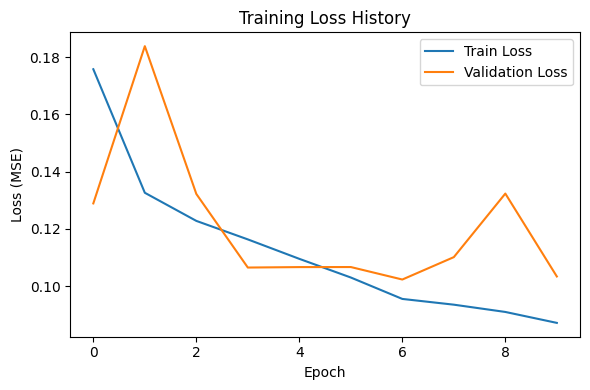

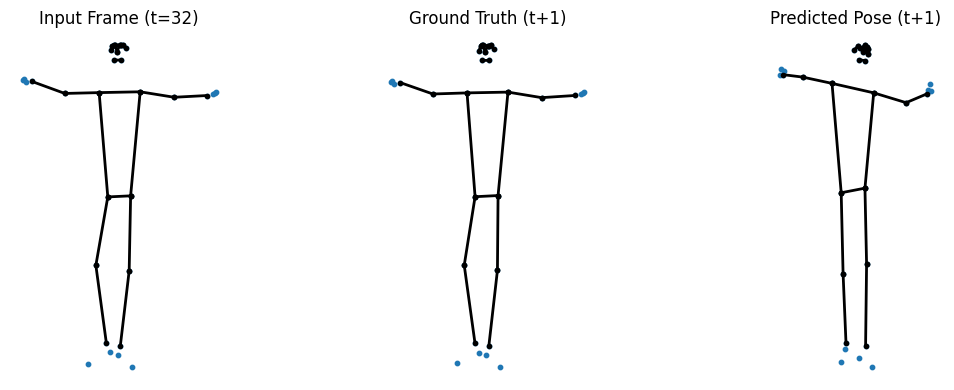

In [25]:
# ---------------------------
# Colab-Safe Execution Block (Training Pipeline)
# ---------------------------
class ColabArgs:
    def __init__(self, drive_path, output_dir, n_videos, epochs, lr):
        self.drive_path = drive_path
        self.output_dir = output_dir
        self.n_videos = n_videos
        self.epochs = epochs
        self.lr = lr

print("Starting ST-GCN Dance Pose Prediction Pipeline (Colab Mode)...\n")

# Use a timestamped folder to save all outputs for easy tracking
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir_ts = Path(CFG["output_dir"]) / timestamp
output_dir_ts.mkdir(parents=True, exist_ok=True)
CFG["output_dir"] = str(output_dir_ts) # Update CFG to use the timestamped path

args = ColabArgs(
    drive_path=CFG["drive_videos_dir"],
    output_dir=CFG["output_dir"],
    n_videos=CFG["sample_videos"],
    epochs=CFG["epochs"],
    lr=CFG["lr"]
)

try:
    print(f"Output files will be saved to: {CFG['output_dir']}\n")
    main(args)
    print("\n✨ Pipeline execution finished. All models and results are saved.")

except Exception as e:
    print(f"\n❌ An error occurred during pipeline execution: {e}")




--- INFERENCE MODE: Loading Models for Pose Generation ---
✅ Retrieved original training configuration (seq_len=32, device=cuda)
✅ Loaded ST-GCN Regressor from: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/stgcn_regressor.pth
✅ Loaded PCA model from: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/pca_transformer.pkl
✅ Loaded K-Means model from: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/kmeans_clusters.pkl

--- Processing selected video: KorvaiAdavu5.mp4 ---


Sampling KorvaiAdavu5.mp4:   0%|          | 0/5574 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KorvaiAdavu5.mp4: 100%|██████████| 5574/5574 [00:53<00:00, 103.81it/s]


Successfully extracted 366 frames. Using first 32 frames as seed.

--- Starting Pose Generation ---
Using video 'KorvaiAdavu5.mp4' as the seed source.


Generating Future Poses: 100%|██████████| 50/50 [00:00<00:00, 657.35it/s]



--- Generation Complete (82 total frames) ---


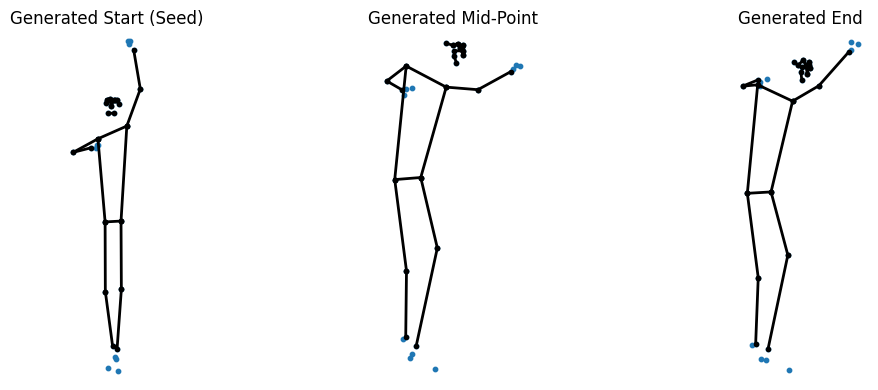

Saved 3D visualization to /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458/final_generated_3d.png


In [32]:
# ---------------------------
# Autoregressive Pose Generation (Inference)
# ---------------------------

# >>>>>> MANUAL INPUT REQUIRED HERE <<<<<<
# Copy and paste the FULL path to your successful training run folder (e.g., ending in /20251122_045800)
output_saved_dir = "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs/MiniBatchKMeans_STGCN/20251122_045800/20251122_052458"

# MINIMAL CFG: Only define what's absolutely needed if CFG hasn't been run.
MINIMAL_CFG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model_path": "stgcn_regressor.pth",
    "pca_model_path": "pca_transformer.pkl",
    "kmeans_model_path": "kmeans_clusters.pkl",
    "drive_videos_dir": "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos", # Needed for sequence sampling
    "proc_fps": 4, # Needed for sequence sampling
    "sample_videos": 15, # Needed for sequence sampling
    "random_seed": 42
}

LOAD_OUT_DIR = Path(output_saved_dir)

print("\n\n--- INFERENCE MODE: Loading Models for Pose Generation ---")

# Load all three saved components AND the definitive CFG used during training
stgcn_model, pca_model, kmeans_model, LOAD_CFG = load_pipeline_models(LOAD_OUT_DIR, MINIMAL_CFG)

# if stgcn_model and LOAD_CFG: # Check if loading was successful
#     # 1. Get an initial sequence (seed) from the validation dataset if available
#     try:
#         # Re-run initial data collection to get the validation sequences structure
#         vpaths = sorted(glob.glob(str(Path(LOAD_CFG["drive_videos_dir"]) / "*.*")))
#         vpaths = [p for p in vpaths if p.lower().endswith(('.mp4','.mov','.avi','.mkv','.webm'))]
#         vpaths = vpaths[: LOAD_CFG["sample_videos"]]

#         # Re-extract all sequences (but don't retrain PCA/K-Means)
#         full_sequences = []
#         for vp in vpaths:
#             # Re-extract the sequences using the same logic as training
#             frames_vecs = []
#             # Note: LOAD_CFG is now used for proc_fps, seq_len, etc.
#             for f_idx, ts, frame in sample_frames_from_video(vp, LOAD_CFG["proc_fps"]):
#                 lm = extract_pose_landmarks(frame)
#                 if lm is None: continue
#                 frames_vecs.append(normalize_landmarks(lm))

#             if len(frames_vecs) >= LOAD_CFG["seq_len"] + LOAD_CFG["pred_horizon"]:
#                 full_sequences.append(np.stack(frames_vecs, axis=0))

#         if full_sequences:
#             random.seed(LOAD_CFG["random_seed"])
#             random.shuffle(full_sequences)
#             n_train = int(0.8 * len(full_sequences))
#             val_seqs = full_sequences[n_train:]

#             # Take the first sequence from the validation set as the seed
#             seed_sequence = val_seqs[0][:LOAD_CFG["seq_len"]]

#             print(f"\n--- Starting Pose Generation ---")
#             print(f"Using a {LOAD_CFG['seq_len']}-frame sequence as seed.")

#             # 2. Generate future poses
#             NUM_TO_GENERATE = 50 # Generate 50 new frames
#             full_generated_sequence = predict_pose_sequence(
#                 stgcn_model,
#                 seed_sequence,
#                 NUM_TO_GENERATE,
#                 LOAD_CFG["device"],
#                 LOAD_CFG["seq_len"]
#             )

#             print(f"\n--- Generation Complete ({full_generated_sequence.shape[0]} total frames) ---")

#             # 3. Visualize a few key frames (e.g., start, middle, end)
#             start_idx = 0
#             mid_idx = seed_sequence.shape[0] + NUM_TO_GENERATE // 2
#             end_idx = -1

#             fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#             plot_stickman(axes[0], full_generated_sequence[start_idx], title="Generated Start (Seed)")
#             plot_stickman(axes[1], full_generated_sequence[mid_idx], title="Generated Mid-Point")
#             plot_stickman(axes[2], full_generated_sequence[end_idx], title="Generated End")
#             plt.tight_layout()
#             plt.savefig(LOAD_OUT_DIR / "generated_sequence_key_frames.png")
#             plt.show()

#             # Optional: Plot the 3D mannequin of the final generated pose
#             plot_3d_mannequin(full_generated_sequence[end_idx], filename=str(LOAD_OUT_DIR / "final_generated_3d.png"))

#         else:
#             print("No complete validation sequences found to use as a seed.")

#     except Exception as e:
#         print(f"❌ Error during inference step: {e}")

if stgcn_model and LOAD_CFG:

    # >>>>>> MANUAL VIDEO INPUT HERE <<<<<<
    # Copy and paste the FULL video path you want to use as the sequence seed.
    USER_VIDEO_PATH = "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KorvaiAdavu5.mp4"
    # >>>>>> END MANUAL INPUT <<<<<<

    try:
        # --- EFFICIENT STEP 1: Extract seed only from the user-selected video ---
        # This calls the fast, single-video processing function.
        seed_sequence = get_seed_sequence_from_video(
            video_path=USER_VIDEO_PATH,
            proc_fps=LOAD_CFG["proc_fps"],
            seq_len=LOAD_CFG["seq_len"]
        )

        # Note: We skip the massive, slow block that used to re-extract all sequences (vpaths, full_sequences, train/val split).

        print(f"\n--- Starting Pose Generation ---")
        print(f"Using video '{os.path.basename(USER_VIDEO_PATH)}' as the seed source.")

        # --- STEP 2: Generate future poses (Autoregressive Loop) ---
        NUM_TO_GENERATE = 50 # Generate 50 new frames
        full_generated_sequence = predict_pose_sequence(
            stgcn_model,
            seed_sequence,
            NUM_TO_GENERATE,
            LOAD_CFG["device"],
            LOAD_CFG["seq_len"]
        )

        print(f"\n--- Generation Complete ({full_generated_sequence.shape[0]} total frames) ---")

        # --- STEP 3: Visualization ---
        start_idx = 0
        mid_idx = seed_sequence.shape[0] + NUM_TO_GENERATE // 2
        end_idx = -1

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        plot_stickman(axes[0], full_generated_sequence[start_idx], title="Generated Start (Seed)")
        plot_stickman(axes[1], full_generated_sequence[mid_idx], title="Generated Mid-Point")
        plot_stickman(axes[2], full_generated_sequence[end_idx], title="Generated End")
        plt.tight_layout()
        plt.savefig(LOAD_OUT_DIR / "generated_sequence_key_frames.png")
        plt.show()

        # Optional: Plot the 3D mannequin of the final generated pose
        plot_3d_mannequin(full_generated_sequence[end_idx], filename=str(LOAD_OUT_DIR / "final_generated_3d.png"))

    except Exception as e:
        print(f"❌ Error during inference step: {e}")